In [1]:
def jansk2vegamag(jansk, filt):
    
    if filt == 'U':
        zp = 1790.
    if filt == 'B':
        zp = 4063.
    if filt == 'V':
        zp = 3636.
    if filt == 'R':
        zp = 3064.
    if filt == 'I':
        zp = 2416.
    
    mag = -2.5*np.log10(jansk/zp)
    return mag

In [2]:
def vegamag2cgs(mag, filt):
    
    #photometric zero points taken from Mann + von Braun, 2015, Table 2
    
    if filt == 'U':
        flam = 4.264e-9
        wid = 1380. #Ang
    if filt == 'B':
        flam = 6.459e-9
        wid = 1816. #Ang
    if filt == 'V':
        flam = 3.735e-9
        wid = 1129. #Ang
    if filt == 'R':
        flam = 2.215e-9
        wid = 1877. #Ang
    if filt == 'I':
        flam = 1.163e-9
        wid = 1604. #Ang.
        
    cgs_flux = wid*flam*10**(-mag / 2.512)
    return cgs_flux

In [3]:
#import packages
import phoebe
from phoebe import u # units
import numpy as np
import csv
from StringIO import StringIO
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from astropy import units as astrou
import emcee
from matplotlib.pyplot import cm 

#set plotting defaults to values that make plots look publication ready
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 11
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'


%matplotlib inline

In [4]:
#set up a logger to track parameters given
logger = phoebe.logger(clevel='INFO', flevel='DEBUG', filename='tutorial.log')

In [5]:
#create a simple binary with a primary and secondary component
b = phoebe.default_binary()

#note that tutorial implies the commands below are needed, 
#but as best I can tell, the default_binary instance has each of these properties by default!

#b.add_orbit('binary')
#b.add_component(phoebe.component.star, component='primary')
#b.add_component('star', component='secondary')

In [6]:
#print b.hierarchy

In [7]:
#now lets read in the light curve 
with open ('/Volumes/CoveyData/APOGEE_Spectra/Anna/Light_curves/2M06464003+0109157.LC.csv', 'rb') as csvfile:
    data = np.genfromtxt(csvfile, dtype = None, delimiter = ',', names = True)
print data.dtype.names
#verify that errors are consistently about 2%
#print data['flux_err'] / data['flux_mJy'] 

#verify that we've converted millijanskies to magnitudes correctly
#print jansk2vegamag(data['flux_mJy']*1e-3,'V')

#roughly convert original magnitudes to flux units 
ergs_flux = vegamag2cgs(data['mag'],'V')
watts_flux = ergs_flux * 1e-3
sigmas = watts_flux * (data['flux_err'] / data['flux_mJy'])
#print watts_flux
#print sigmas

#also encode the system period
sys_period = 1.06493  #system period (in days)


('hjd', 'camera', 'filter', 'mag', 'mag_err', 'flux_mJy', 'flux_err')


/Users/kcovey/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  This is separate from the ipykernel package so we can avoid doing imports until


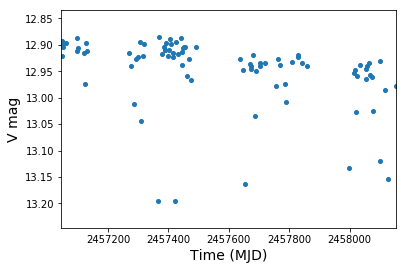

In [8]:
#now let's plot the light curve
early = np.amin(data['hjd'])
late = np.amax(data['hjd'])
bright = np.amin(data['mag'])
faint = np.amax(data['mag'])
plt.scatter(data['hjd'], data['mag']) 
xlabel = plt.xlabel('Time (MJD)') 
ylabel = plt.ylabel('V mag')
plt.axis([early, late,faint+0.05,bright-0.05])
plt.savefig('2M06464003+0109157.LC.png', bbox_inches='tight')    

In [9]:
#try adding the fluxes from the light curve
b.add_dataset(phoebe.dataset.lc, times=data['hjd'], fluxes=watts_flux, sigmas=watts_flux * (data['flux_err'] / data['flux_mJy']), passband = 'Johnson:V', dataset='lc01')

Mon, 12 Aug 2019 21:02 PASSBANDS    WARNING connection to online passbands at http://github.com/phoebe-project/phoebe2-tables could not be established


<ParameterSet: 15 parameters | contexts: compute, dataset>

In [10]:
#tell the system to ignore irradiative effects, and reduce the number of triangles to calculate to simply the calculation
b.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
b.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
b.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

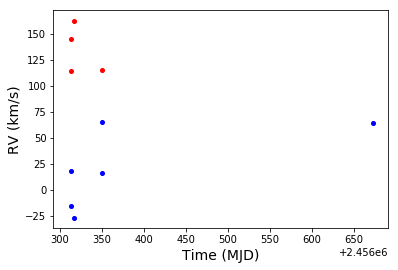

In [11]:
prim_rvs = [17.75904864, -27.08610139, 16.16515397, -15.2494635, 65.17218503, 64.1549002]
prim_rv_times = [2456312.76, 2456316.753, 2456349.672, 2456313.757, 2456350.68, 2456672.801]

sec_rvs = [114.480622, 162.325257, 114.878743, 145.4263568]
sec_rv_times = [2456312.76, 2456316.753, 2456349.672, 2456313.757]

plt.scatter(prim_rv_times, prim_rvs, color = 'b') 
plt.scatter(sec_rv_times, sec_rvs, color = 'r') 

xlabel = plt.xlabel('Time (MJD)') 
ylabel = plt.ylabel('RV (km/s)')
#plt.axis([early, late,faint+0.05,bright-0.05])
plt.savefig('2M06464003+0109157.RV.png', bbox_inches='tight')  



#b.add_dataset('rv', times=[0,1], rvs=[-3,3], dataset='rv03')

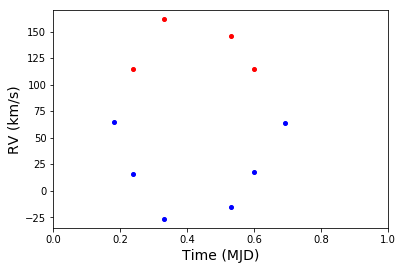

In [12]:
plt.scatter(np.array(prim_rv_times) % sys_period, prim_rvs, color = 'b') 
plt.scatter(np.array(sec_rv_times) % sys_period, sec_rvs, color = 'r') 

xlabel = plt.xlabel('Time (MJD)') 
ylabel = plt.ylabel('RV (km/s)')
plt.axis([0, 1, -35, 170])
plt.savefig('2M06464003+0109157.RV.phased.png', bbox_inches='tight')  

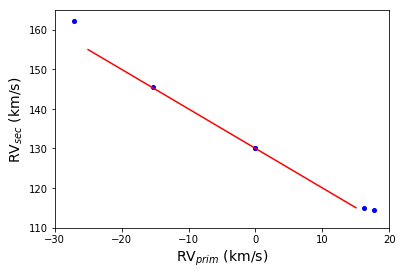

In [13]:
#fake a set of 1-by-1 datapoints
xes = np.arange(-25,25,10)
yes = np.flip(np.arange(115,165,10))
plt.plot(xes, yes, color = 'r')

#show the data where we actually measured the two components
plt.scatter(prim_rvs[0:4], sec_rvs, color = 'b') 

#fake two datapoints that assume the measured RVs of 65 km/s is a 
#compromise between the primary velocity of zero, and the secondary velocity of 130.
plt.scatter([0,0], [130, 130], color = 'b')
xlabel = plt.xlabel('RV$_{prim}$ (km/s)') 
ylabel = plt.ylabel('RV$_{sec}$ (km/s)')
plt.axis([-30, 20,110,165])
plt.savefig('2M06464003+0109157.Wilson.png', bbox_inches='tight')  

In [14]:
b.add_dataset('rv', times=prim_rv_times[0:4], rvs={'primary': prim_rvs[0:4], 'secondary': sec_rvs}, dataset='rv04')

Mon, 12 Aug 2019 21:02 PASSBANDS    WARNING connection to online passbands at http://github.com/phoebe-project/phoebe2-tables could not be established


<ParameterSet: 15 parameters | contexts: compute, dataset>

In [15]:
#set initial system parameters
b['incl@binary@orbit@component'] = 88.0  #assume close to edge on
b['period@orbit'] = sys_period
b['teff@primary'] = 4000.  
b['teff@secondary'] = 4000.
b['q@binary@orbit@component'] = 1.0  #assume nearly equal mass
b['requiv@primary@star@component'] = 1.1
b['requiv@secondary@star@component'] = 0.9
b['mass@primary@constraint'] = 0.7
b['mass@secondary@constraint'] = 0.7

#b['pblum@primary@dataset'] = 2.9*np.pi

In [16]:
#compute the existing model on this dataset
b.run_compute()

Mon, 12 Aug 2019 21:02 BUNDLE       INFO    running phoebe backend to create 'latest' model
Mon, 12 Aug 2019 21:02 PASSBANDS    INFO    loading Johnson:V passband


<ParameterSet: 6 parameters | kinds: rv, lc>

Mon, 12 Aug 2019 21:02 PARAMETERS   INFO    calling autofig.plot(i=<data ((4,))>, label=primary@rv04, y=<data ((4,))>, xlabel=time, ylabel=rv, marker=none, x=<data ((4,))>, z=0)
Mon, 12 Aug 2019 21:02 PARAMETERS   INFO    calling autofig.plot(i=<data ((4,))>, label=secondary@rv04, y=<data ((4,))>, xlabel=time, ylabel=rv, marker=none, x=<data ((4,))>, z=0)
Mon, 12 Aug 2019 21:02 PARAMETERS   INFO    calling autofig.plot(i=<data ((90,))>, label=lc01, y=<data ((90,))>, xlabel=time, ylabel=flux, marker=none, x=<data ((90,))>, z=0)
Mon, 12 Aug 2019 21:02 PARAMETERS   INFO    calling autofig.plot(i=<data ((4,))>, label=primary@rv04, xlabel=time, ylabel=rv, y=<data ((4,))>, x=<data ((4,))>, z=0, linestyle=none)
Mon, 12 Aug 2019 21:02 PARAMETERS   INFO    calling autofig.plot(i=<data ((4,))>, label=secondary@rv04, xlabel=time, ylabel=rv, y=<data ((4,))>, x=<data ((4,))>, z=0, linestyle=none)
Mon, 12 Aug 2019 21:02 PARAMETERS   INFO    calling autofig.plot(i=<data ((90,))>, ylabel=flux, label=l

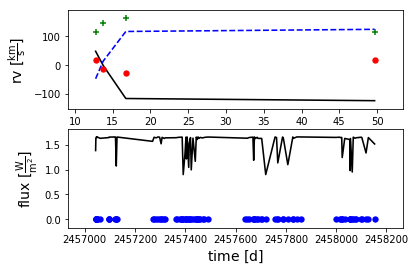

(<Figure | 2 axes | 6 call(s)>, <Figure size 432x288 with 2 Axes>)

In [17]:
b.plot(show=True)

In [18]:
model_fluxes = b['fluxes@latest@model'].get_value()
#model_sigmas = b['sigmas@latest@model'].get_value()
print(model_fluxes)
#print(model_sigmas)

[1.38321518 1.63227345 1.64797426 1.65590556 1.65345329 1.64454216
 1.65670993 1.62973528 1.64480407 1.65537547 1.65408044 1.65727915
 1.65017948 1.07204769 1.65564157 1.56896458 1.65040884 1.63886419
 1.65707294 1.65290121 1.51946    1.64902684 1.62740762 1.63902031
 1.64253734 1.6470873  1.65146075 1.65172899 1.65727964 1.63686001
 0.90013672 1.31065186 1.65372554 1.2149421  1.65571305 1.0449704
 1.53074584 1.64469782 0.99492695 1.63406863 1.16710326 1.65427408
 1.62726889 1.60661102 1.65767423 1.62874572 1.64776865 1.63751646
 1.64812132 1.65583745 1.63340296 1.63168813 1.6454343  1.65346793
 1.18819972 1.65712119 1.62653544 1.65000437 1.62845341 1.62753667
 1.62833677 0.90019274 1.65594206 1.64585195 1.13530034 1.65583747
 1.6383037  1.10009183 1.65705911 1.62893253 1.65800358 1.65719052
 1.64818072 1.65210372 1.64204361 1.648444   1.24273693 1.62746799
 1.60480443 0.97895124 1.62650673 0.95122587 1.65323826 1.63091397
 1.64077312 1.65191707 1.64716136 1.33521984 1.6445947  1.51595

In [19]:
#set up an mcmc fit
nwalkers = 256
niter = 1000
init_dist = [(86.0,90),(1.06493,1.06493),(4100,3900),(4100,3900),(1.05,0.95), (1.00,1.1), (0.9,1.0), (0.675,0.725), (0.675, 0.725)  ]
priors = [(86.0,90),(1.06485,1.06501),(4250,3750),(4250,3750),(1.1,0.9),(0.9,1.15),(0.85,1.1),(0.6,0.75), (0.6, 0.75) ]

#define a model object
mod = phoebe.default_binary()
mod.add_dataset('lc', times = data['hjd'], fluxes=watts_flux, sigmas=sigmas,compute_phases=np.linspace(0,1.,51), passband='Johnson:V')

Mon, 12 Aug 2019 21:02 PASSBANDS    WARNING connection to online passbands at http://github.com/phoebe-project/phoebe2-tables could not be established
Mon, 12 Aug 2019 21:02 BUNDLE       WARNING 'compute_phases' not a recognized kwarg


<ParameterSet: 15 parameters | contexts: compute, dataset>

In [20]:
mod.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
mod.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
mod.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)

In [21]:
def rpars(init_dist):
    return [np.random.rand() * (i[1]-i[0]) + i[0] for i in init_dist]

In [22]:
def lnprior(priors, values):
    
    lp = 0.
    for value, prior in zip(values, priors):
        if value >= prior[0] and value <= prior[1]:
            lp+=0
        else:
            lp+=-np.inf 
    return lp

In [23]:
def lnprob(z):

    b['incl@binary@orbit@component'] = z[0]  #assume close to edge on
    b['period@orbit'] = z[1]
    b['teff@primary'] = z[2]  
    b['teff@secondary'] = z[3]
    b['q@binary@orbit@component'] = z[4]  #assume nearly equal mass
    b['requiv@primary@star@component'] = z[5]
    b['requiv@secondary@star@component'] = z[6]
    b['mass@primary@constraint'] = z[7]
    b['mass@secondary@constraint'] = z[8]
    lnp = lnprior(priors,z)
    if not np.isfinite(lnp):
            return -np.inf
    
    try: 
        mod.run_compute()

        # use chi^2 to compare the model to the data:
        chi2 = 0.
        for dataset in mod.get_model().datasets:
            chi2+=np.sum(mod.compute_residuals(dataset=dataset, as_quantity=False)**2/sigmas**2)
        # calculate lnprob
        lnprob = -0.5*chi2 + lnp
        return lnprob
    except:
        return -np.inf

In [24]:
def run(init_dist, nwalkers, niter):
    # Specify the number of dimensions for mcmc
    ndim = len(init_dist)

    # Generate initial guesses for all parameters for all chains
    p0 = np.array([rpars(init_dist) for i in xrange(nwalkers)])

    # Generate the emcee sampler. Here the inputs provided include the lnprob function. With this setup, the value z
    # in the lnprob function, is the output from the sampler.
    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob)
    
    #pos is the position of the walkers in parameter space
    #prob is the probability of the given "pos" positions
    #state is the state of the random number generator
    pos, prob, state = sampler.run_mcmc(p0, niter)

    for i in range(ndim):
        plt.figure()
        y = sampler.flatchain[:,i]
        n, bins, patches = plt.hist(y, 200, normed=1, color="b", alpha=0.45)#, histtype="step")
        plt.title("Dimension {0:d}".format(i))
        
        mu = np.average(y)
        sigma = np.std(y)
        
        print "mu = ", mu
        print "sigma = ",sigmas

        bf = mlab.normpdf(bins, mu, sigma)
        l = plt.plot(bins, bf, 'k--', linewidth=2.0)
    plt.show()
    return pos

/Users/kcovey/anaconda3/envs/py2/lib/python2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/kcovey/anaconda3/envs/py2/lib/python2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))
/Users/kcovey/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/kcovey/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


mu =  87.92369837311091
sigma =  [5.28481874e-16 5.58537987e-16 5.36669442e-16 5.65153548e-16
 4.84680788e-16 5.62937776e-16 5.57063225e-16 5.50166267e-16
 5.60755403e-16 5.35231314e-16 5.03259632e-16 5.69008742e-16
 5.69987685e-16 5.63044799e-16 5.44502230e-16 5.66407165e-16
 5.53681596e-16 5.71381305e-16 5.62156208e-16 5.50508889e-16
 5.69051554e-16 5.56224626e-16 5.30760978e-16 5.93410331e-16
 5.74886789e-16 5.59528898e-16 5.44331077e-16 5.54817994e-16
 5.30488698e-16 5.67474630e-16 5.62871360e-16 5.70976219e-16
 5.47923693e-16 5.52879916e-16 5.43368694e-16 5.63111509e-16
 5.29431543e-16 5.56263685e-16 5.48073499e-16 5.58284993e-16
 5.51474703e-16 5.39778671e-16 5.69975046e-16 5.28800233e-16
 4.84680788e-16 5.41081802e-16 5.42429569e-16 5.70124842e-16
 5.66557099e-16 5.47849518e-16 5.08814915e-16 5.69022526e-16
 5.73753484e-16 5.55074964e-16 5.57255973e-16 5.48254906e-16
 5.49129670e-16 5.46890726e-16 5.26069144e-16 5.46890726e-16
 5.91259005e-16 5.85417249e-16 5.59528158e-16 5.7574

mu =  0.6998113537416398
sigma =  [5.28481874e-16 5.58537987e-16 5.36669442e-16 5.65153548e-16
 4.84680788e-16 5.62937776e-16 5.57063225e-16 5.50166267e-16
 5.60755403e-16 5.35231314e-16 5.03259632e-16 5.69008742e-16
 5.69987685e-16 5.63044799e-16 5.44502230e-16 5.66407165e-16
 5.53681596e-16 5.71381305e-16 5.62156208e-16 5.50508889e-16
 5.69051554e-16 5.56224626e-16 5.30760978e-16 5.93410331e-16
 5.74886789e-16 5.59528898e-16 5.44331077e-16 5.54817994e-16
 5.30488698e-16 5.67474630e-16 5.62871360e-16 5.70976219e-16
 5.47923693e-16 5.52879916e-16 5.43368694e-16 5.63111509e-16
 5.29431543e-16 5.56263685e-16 5.48073499e-16 5.58284993e-16
 5.51474703e-16 5.39778671e-16 5.69975046e-16 5.28800233e-16
 4.84680788e-16 5.41081802e-16 5.42429569e-16 5.70124842e-16
 5.66557099e-16 5.47849518e-16 5.08814915e-16 5.69022526e-16
 5.73753484e-16 5.55074964e-16 5.57255973e-16 5.48254906e-16
 5.49129670e-16 5.46890726e-16 5.26069144e-16 5.46890726e-16
 5.91259005e-16 5.85417249e-16 5.59528158e-16 5.757

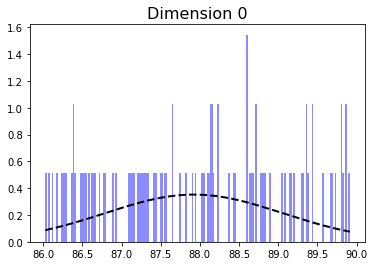

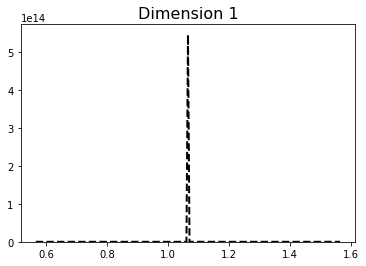

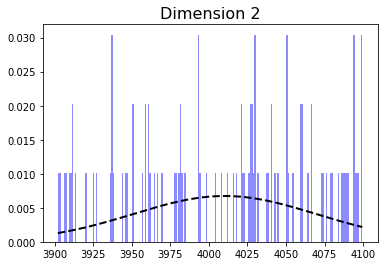

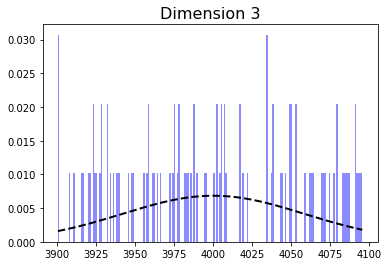

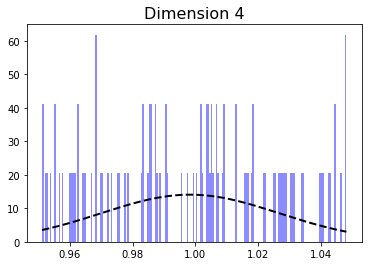

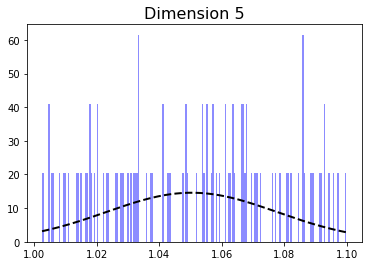

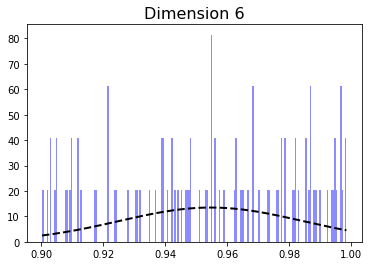

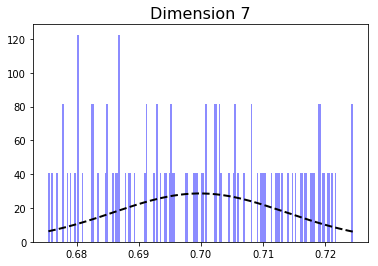

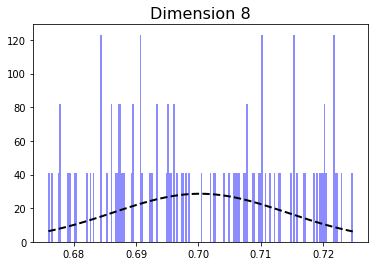

In [25]:
pos = run(init_dist, nwalkers, niter)

In [26]:
color=cm.rainbow(np.linspace(0,1,nwalkers))
for i,c in zip(range(nwalkers),color):
  
    #pl.figure()
    
    # Set all the parameter values
    b['incl@binary@orbit@component'] = pos[-1-i,0]  #assume close to edge on
    b['period@orbit'] = pos[-1-i,1]
    b['teff@primary'] = pos[-1-i,2]
    b['teff@secondary'] = pos[-1-i,3]
    b['q@binary@orbit@component'] = pos[-1-i,4]  #assume nearly equal mass
    b['requiv@primary@star@component'] = pos[-1-i,5]
    b['requiv@secondary@star@component'] = pos[-1-i,6]
    b['mass@primary@constraint'] = pos[-1-i,7]
    b['mass@secondary@constraint'] = pos[-1-i,8]
 
    mod.run_compute(model='run{}'.format(i))

Tue, 13 Aug 2019 00:17 BUNDLE       INFO    running phoebe backend to create 'run0' model
Tue, 13 Aug 2019 00:17 BUNDLE       INFO    running phoebe backend to create 'run1' model
Tue, 13 Aug 2019 00:17 BUNDLE       INFO    running phoebe backend to create 'run2' model
Tue, 13 Aug 2019 00:17 BUNDLE       INFO    running phoebe backend to create 'run3' model
Tue, 13 Aug 2019 00:17 BUNDLE       INFO    running phoebe backend to create 'run4' model
Tue, 13 Aug 2019 00:17 BUNDLE       INFO    running phoebe backend to create 'run5' model
Tue, 13 Aug 2019 00:17 BUNDLE       INFO    running phoebe backend to create 'run6' model
Tue, 13 Aug 2019 00:18 BUNDLE       INFO    running phoebe backend to create 'run7' model
Tue, 13 Aug 2019 00:18 BUNDLE       INFO    running phoebe backend to create 'run8' model
Tue, 13 Aug 2019 00:18 BUNDLE       INFO    running phoebe backend to create 'run9' model
Tue, 13 Aug 2019 00:18 BUNDLE       INFO    running phoebe backend to create 'run10' model
Tue, 13 A

Tue, 13 Aug 2019 00:30 BUNDLE       INFO    running phoebe backend to create 'run91' model
Tue, 13 Aug 2019 00:30 BUNDLE       INFO    running phoebe backend to create 'run92' model
Tue, 13 Aug 2019 00:30 BUNDLE       INFO    running phoebe backend to create 'run93' model
Tue, 13 Aug 2019 00:30 BUNDLE       INFO    running phoebe backend to create 'run94' model
Tue, 13 Aug 2019 00:30 BUNDLE       INFO    running phoebe backend to create 'run95' model
Tue, 13 Aug 2019 00:30 BUNDLE       INFO    running phoebe backend to create 'run96' model
Tue, 13 Aug 2019 00:31 BUNDLE       INFO    running phoebe backend to create 'run97' model
Tue, 13 Aug 2019 00:31 BUNDLE       INFO    running phoebe backend to create 'run98' model
Tue, 13 Aug 2019 00:31 BUNDLE       INFO    running phoebe backend to create 'run99' model


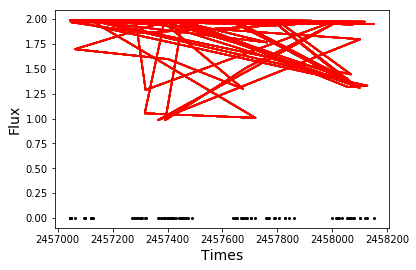

KeyError: 0

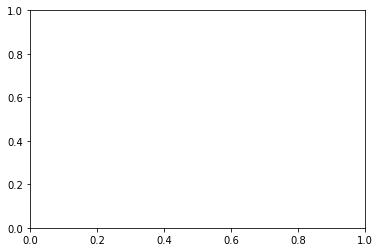

In [29]:
for i,c in zip(range(nwalkers),color):
    model = mod['fluxes@run{}'.format(i)].interp_value(times=data['hjd'])

    plt.plot(data['hjd'],model,c=c)

plt.xlabel("Times")
plt.ylabel("Flux")
plt.plot(data['hjd'],watts_flux,"k.")
plt.show()

phases = mod.to_phase(data['hjd'])
phases_sorted = sorted(phases)
for i,c in zip(range(nwalkers),color):
    model = mod['fluxes@run{}'.format(i)] #.interp_value(phases=phases_sorted)

    plt.plot(phases_sorted,model,c=c)

plt.xlabel("Times")
plt.ylabel("Flux")
plt.plot(phases,watts_flux,"k.")
plt.show()